In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # for splitting the training data

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import GradientBoostingRegressor as GBR

# for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
Kfold_validation = KFold(10) # use k=10 for cross validation

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and validate the training and testing data

In [114]:
# Load the preprocessed training data
train_processed = pd.read_csv('train_processed.csv')
print("Training data shape:", train_processed.shape)
print("Columns:", train_processed.columns.tolist())

# Separate features (X) and target (y)
y_train = train_processed['Price']
X_train = train_processed.drop(columns=['Price'])


print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget statistics:")
print(f"Mean price: {y_train.mean():.2f}")
print(f"Min price: {y_train.min():.2f}")
print(f"Max price: {y_train.max():.2f}")

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=20
)
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training data shape: (4336, 21)
Columns: ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Price', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Features shape: (4336, 20)
Target shape: (4336,)

Target statistics:
Mean price: 9.65
Min price: 0.44
Max price: 160.00
Training set: (3902, 20)
Validation set: (434, 20)


# Random Forest Regressor model

In [ ]:
# Train a Random Forest Regressor model with optimized parameters
print("Training Random Forest model...")
rf_model = RF(
    n_estimators=490,              # More trees for better stability
    max_depth=20,                  # No limit - allow trees to grow fully
    min_samples_split=2,           # Allow more splits for fine-tuning
    min_samples_leaf=1,            # Minimum samples at leaf nodes
    max_features='sqrt',           # sqrt(n_features) at each split =sqrt(20) ~4
    criterion='absolute_error',     # Better aligned with MAPE metric
    bootstrap=True,                # Use bootstrap sampling
    max_samples=0.8,               # Use 80% of samples for each tree
    random_state=42,
    n_jobs=-1                      # Use all CPU cores
)

rf_model.fit(X_train_split, y_train_split)

# Make predictions
y_pred_val_rf = rf_model.predict(X_val)

# Evaluate the model
print("\n=== Random Forest Model Performance ===")
print(f"Training MAPE: {calculate_mape(y_train_split, rf_model.predict(X_train_split)):.2f}%")
print(f"Validation MAPE: {calculate_mape(y_val, y_pred_val_rf):.2f}%")


# perform cross validation to evaluate the testing error

# Create custom MAPE scorer (negative because lower is better)
mape_scorer = make_scorer(
    lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
    greater_is_better=False  # Lower MAPE is better
)

rf_model_cross_validation_result = cross_val_score(
    rf_model, 
    X_train, 
    y_train, 
    cv=Kfold_validation,
    scoring=mape_scorer,
    n_jobs=-1  # Parallel processing
)

print("\n=== Cross validation result ===")
print(-rf_model_cross_validation_result)
print("\n=== Cross validation mean MAPE ===")
print(f"{np.mean(-rf_model_cross_validation_result):.2f}%")

Training Random Forest model...

=== Random Forest Model Performance ===
Training MAPE: 10.06%
Validation MAPE: 22.52%

=== Cross validation result ===
[22.81437273 19.29095583 28.42233963 21.86007005 20.82542031 22.86892156
 21.67037697 19.99774474 20.22736908 20.37263964]

=== Cross validation mean MAPE ===
21.84%


In [ ]:
# Load test_processed.csv and predict the price
test_processed = pd.read_csv('test_processed.csv')
print("Test data shape:", test_processed.shape)
print("Test data columns:", test_processed.columns.tolist())

# Save ID column if it exists
X_test = test_processed.drop(columns=['ID'])

print(f"\nTest features shape: {X_test.shape}")
print(f"Training features shape: {X_train.shape}")

# Verify columns match between train and test
print(f"\nColumns match: {list(X_train.columns) == list(X_test.columns)}")

In [ ]:
# Make predictions using Random Forest model
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest Predictions ===")
print(f"Predicted prices - Min: {y_pred_rf.min():.2f}, Max: {y_pred_rf.max():.2f}, Mean: {y_pred_rf.mean():.2f}")

# Save ID and predicted Price to CSV file
submission_dt = pd.DataFrame({
    'ID': test_processed['ID'],
    'Price': y_pred_rf
})

submission_dt.to_csv('submission_random_tree_forest.csv', index=False)
print("\nDecision Tree submission saved as submission_random_tree_forest.csv")


=== Top 15 Most Important Features ===
               feature  importance
                 Power    0.285027
                Engine    0.182853
                   Age    0.107107
   Transmission_Manual    0.083785
Transmission_Automatic    0.082652
     Kilometers_Driven    0.080535
               Mileage    0.067216
      Fuel_Type_Diesel    0.025554
                 Seats    0.024642
      Fuel_Type_Petrol    0.019274
          No. of Doors    0.014919
      Owner_Type_First    0.005855
          Colour_White    0.005813
         Colour_Others    0.004769
   Colour_Black/Silver    0.004677


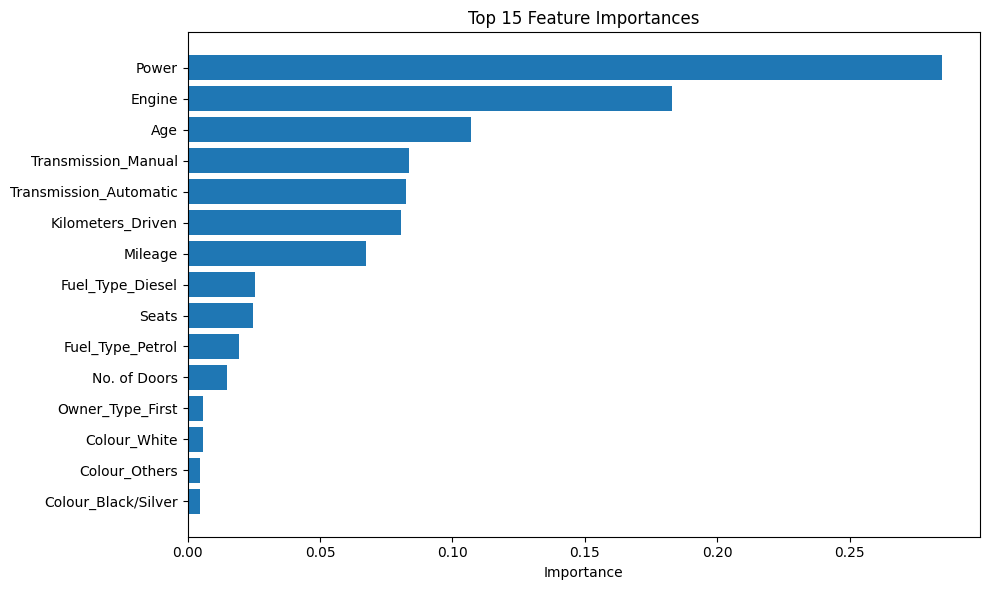

In [118]:
# Feature importance from XGBoost
import matplotlib.pyplot as plt

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features ===")
print(feature_importance_xgb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb.head(15)['feature'], feature_importance_xgb.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()